In [1]:
root_path = "/content/drive/MyDrive"
import numpy as np
import pandas as pd 
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
import tensorflow as tf
print(tf.test.gpu_device_name())
drive.mount('/content/drive')

/device:GPU:0
Mounted at /content/drive


In [3]:
# parameters
varAOD = 'nAODm'
varPM = 'PMc'

name = 'train' + ".csv"
path = os.path.join(root_path, 'final_data', name)

dftrain = pd.read_csv(path)


Xtrain = dftrain[[varAOD, 'lat', 'long', 'Prob_bestm','d2m', 't2m', 'blh',
                  'sp', 'lai_hv', 'ws10', 'wd10', 'uvb', 'RH', 'DOY']]
ytrain = dftrain.loc[:,['PMc']]

scaler = MinMaxScaler()
Xstrain = scaler.fit_transform(Xtrain)
ytrain = ytrain.to_numpy()

print(Xstrain.shape)

(15848, 14)


# Model

In [4]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = os.path.join(root_path, "final_data/AQ1-saved_model")
fold_var = 1

In [5]:
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
n_inputs = Xstrain.shape[1]

# define encoder
visible = Input(shape=(n_inputs,))
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(visible)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(e)
# define bottleneck
n_bottleneck = 10
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(bottleneck)
d=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 3006.84546, saving model to /content/drive/MyDrive/final_data/AQ1-saved_model/model_1.h5
397/397 - 8s - loss: 8378.0771 - val_loss: 3006.8455 - 8s/epoch - 20ms/step
Epoch 2/200

Epoch 00002: val_loss improved from 3006.84546 to 2578.57788, saving model to /content/drive/MyDrive/final_data/AQ1-saved_model/model_1.h5
397/397 - 3s - loss: 2950.3899 - val_loss: 2578.5779 - 3s/epoch - 8ms/step
Epoch 3/200

Epoch 00003: val_loss improved from 2578.57788 to 2259.89014, saving model to /content/drive/MyDrive/final_data/AQ1-saved_model/model_1.h5
397/397 - 3s - loss: 2590.5513 - val_loss: 2259.8901 - 3s/epoch - 8ms/step
Epoch 4/200

Epoch 00004: val_loss improved from 2259.89014 to 2112.30200, saving model to /content/drive/MyDrive/final_data/AQ1-saved_model/model_1.h5
397/397 - 3s - loss: 2394.9563 - val_loss: 2112.3020 - 3s/epoch - 8ms/step
Epoch 5/200

Epoch 00005: val_loss did not improve from 2112.30200
397/397 - 3s - loss: 2283.2698 

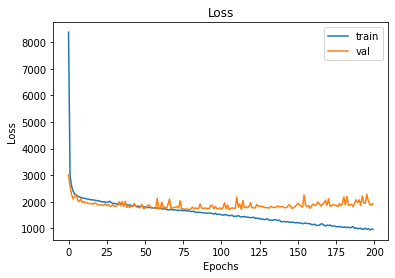

In [6]:
# compile autoencoder model
 
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, get_model_name(fold_var)), 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')

callbacks_list = [checkpoint]

# fit the autoencoder model to reconstruct input
history = model.fit(Xstrain, ytrain, epochs=200, verbose=2, validation_split=0.2, callbacks=callbacks_list)
# plot val and loss
plot_history(history)

In [7]:
from keras.models import load_model
# LOAD BEST MODEL to evaluate the performance of the model
save_dir = os.path.join(root_path, "final_data/AQ1-saved_model")
fold_var = 1

# load model
model = load_model(os.path.join(save_dir, get_model_name(fold_var)))

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# encode the train data
X_train_encode = encoder.predict(Xstrain)


In [8]:
# define the model
from sklearn.svm import SVR
reg = SVR(kernel='rbf', C=100, gamma='auto', epsilon=.1)
# fit the model on the training set
reg.fit(X_train_encode, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma='auto')

# Train

In [9]:
########## Train
dftrain["y_pred"] = reg.predict(X_train_encode)

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
dftrain["PMp"] = dftrain.apply(NominalPM, axis = 1)
RMSE = np.round(mean_squared_error(dftrain["PM2.5"], dftrain["PMp"], squared=False), 2)
MAE = np.round(mean_absolute_error(dftrain["PM2.5"], dftrain["PMp"]), 2)
print ("RMSE: ", RMSE)
print ("MAE: ", MAE)
from scipy.stats import pearsonr
corr, _ = pearsonr(dftrain["y_pred"], dftrain["PMc"])
print('Pearsons R2 correlation: %.2f' % corr**2)

RMSE:  7.97
MAE:  6.03
Pearsons R2 correlation: 0.83


# Test 

In [10]:
name = 'test' + ".csv"
path = os.path.join(root_path, 'final_data', name)
dftest = pd.read_csv(path)


Xtest = dftest[[varAOD, 'lat', 'long', 'Prob_bestm','d2m', 't2m', 'blh',
                  'sp', 'lai_hv', 'ws10', 'wd10', 'uvb', 'RH', 'DOY']]
ytest = dftest.loc[:,['PMc']]
ytest = ytest.to_numpy()
Xstest = scaler.fit_transform(Xtest)

start = time.time()
X_test_encode = encoder.predict(Xstest)
dftest["y_pred"] = reg.predict(X_test_encode)
print("Time elapsed: ", time.time() - start)

dftest["PMp"] = dftest.apply(NominalPM, axis = 1)
RMSE = np.round(mean_squared_error(dftest["PM2.5"], dftest["PMp"], squared=False),2)
MAE = np.round(mean_absolute_error(dftest["PM2.5"], dftest["PMp"]),2)
print ("RMSE: ", RMSE)
print ("MAE: ", MAE)
corr, _ = pearsonr(dftest["y_pred"], dftest["PMc"])
print('Pearsons R2 correlation: %.2f' % corr**2)

Time elapsed:  7.617049217224121
RMSE:  9.75
MAE:  7.32
Pearsons R2 correlation: 0.68
